## How to Run

1. Run the steps in the main README.

2. For MPC authentication, get your subscription key from [here](https://planetarycomputer.developer.azure-api.net/profile) and run `planetarycomputer configure` in terminal and paste is there. Further instructions [here](https://planetarycomputer.microsoft.com/docs/concepts/sas/#:~:text=data%20catalog.-,planetary%2Dcomputer%20Python%20package,-The%20planetary%2Dcomputer).

3. Set your required search time window, image size, and number of features in the parameters section.

4. Run the notebook.

#### To Do:
- Can we go older than 2013? No Landsat 7 on this endpoint...
- Add column to output CSV to record why a no features where returned for a requested point
- Read parameters from .yml/.json
- Match dimensions of composited vs raw image tensors

In [6]:
import warnings
import os
import gc
from pathlib import Path

from tqdm.notebook import tqdm

import torch
from torch.utils.data import DataLoader

import numpy as np
import pandas as pd
import geopandas as gpd
import dask_geopandas as dask_gpd
#from dask.distributed import Client
#from dask_gateway import GatewayCluster

import matplotlib.pyplot as plt

In [7]:
from custom.mosaiks_points import load_points_gdf

from custom.mpc_imagery import (
    sort_by_hilbert_distance,
    fetch_stac_items, 
    CustomDataset
)
from custom.models import featurize, RCF
from custom.mosaiks_data import save_features_to_parquet

In [8]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.WARNING)

In [9]:
warnings.filterwarnings(action="ignore", category=RuntimeWarning)
warnings.filterwarnings(action="ignore", category=UserWarning)

In [10]:
RASTERIO_BEST_PRACTICES = dict(  # See https://github.com/pangeo-data/cog-best-practices
    CURL_CA_BUNDLE="/etc/ssl/certs/ca-certificates.crt",
    GDAL_DISABLE_READDIR_ON_OPEN="EMPTY_DIR",
    AWS_NO_SIGN_REQUEST="YES",
    GDAL_MAX_RAW_BLOCK_CACHE_SIZE="200000000",
    GDAL_SWATH_SIZE="200000000",
    VSI_CURL_CACHE_SIZE="200000000",
)
os.environ.update(RASTERIO_BEST_PRACTICES)

In [11]:
ROOT = Path.cwd().parent
DATA_ROOT = ROOT / "data"

## Set parameters

Note: Earliest L8 imagery is April 2013 so we pick the least cloudy (or least cloudy composite) image from the 1 year window after this date. Latest imagery is March 2022, so we take 1 year window prior to this date.

In [12]:
data_label = "2021_exact_2400m_v4000_S2"

In [13]:
search_start = "2021-04-01" #"2021-04-01" #"2015-11-01"
search_end = "2022-03-31" #"2022-03-31" #"2016-10-31"
NUM_FEATURES = 4000

In [14]:
# # LANDSAT PARAMETERS
# satellite = "landsat-8-c2-l2"
# resolution = 30
# bands = [
#     # "SR_B1", # Coastal/Aerosol Band (B1)
#     "SR_B2",  # Blue Band (B2)
#     "SR_B3",  # Green Band (B3)
#     "SR_B4",  # Red Band (B4)
#     "SR_B5",  # Near Infrared Band 0.8 (B5)
#     "SR_B6",  # Short-wave Infrared Band 1.6 (B6)
#     "SR_B7",  # Short-wave Infrared Band 2.2 (B7)
# ]
# BUFFER_DISTANCE = 1200 # gives 80x80px pics for 10m resolution
# NUM_INPUT_CHANNELS = 6
# # for image fetching
# min_image_edge = 30


# ## SENTINEL PARAMETERS
satellite = "sentinel-2-l2a"
resolution = 10
bands = [  # Sentinel-2 Bands
    "B02", # B02 (blue) 10 meter
    "B03", # B03 (green) 10 meter
    "B04", # B04 (red) 10 meter
    "B05", # B05(Veg Red Edge 1) 20 meter
    "B06", # B06(Veg Red Edge 2) 20 meter
    "B07", # B07(Veg Red Edge 3) 20 meter
    "B08", # B08 (NIR) 10 meter
    "B11", # B11 (SWIR (1.6)) 20 meter
    "B12", # B12 (SWIR (2.2)) 20 meter
]
BUFFER_DISTANCE = 1200 # gives 240x240px pics at 10m resolution
NUM_INPUT_CHANNELS = 9
# for image fetching
min_image_edge = 90

## Load point coordinates and get overlapping image refs

 ### If never run before, fetch and save refs to file:

In [15]:
# static (single-machine workers)
client = Client(n_workers=8)
print(client.dashboard_link)
# # OR adaptive Dask client (multi-machine)
# cluster = GatewayCluster()
# client = cluster.get_client()
# cluster.adapt(minimum=4, maximum=24)
# print(cluster.dashboard_link)

filepath = DATA_ROOT / "01_preprocessed/mosaiks_request_points" / "urb_rur_request_points.csv"
points_gdf = load_points_gdf(filepath)
# has 99,897 points

NUM_POINTS = len(points_gdf)
print("No. points loaded:", NUM_POINTS)

points_gdf = sort_by_hilbert_distance(points_gdf)

# Convert to DaskGeoDataFrame for parallelization
NPARTITIONS = 250
points_dgdf = dask_gpd.from_geopandas(points_gdf, npartitions=NPARTITIONS, sort=False)


## Fetch the image refs
# Note: `meta` is the expected output format: an empty df with correct column types
meta = points_dgdf._meta
meta = meta.assign(stac_item=pd.Series([], dtype="object"))
meta = meta.assign(cloud_cover=pd.Series([], dtype="object"))

points_gdf_with_stac = points_dgdf.map_partitions(
    fetch_stac_items, 
    satellite=satellite,
    search_start=search_start,
    search_end=search_end,
    stac_output="least_cloudy",
    meta=meta)

points_gdf_with_stac = points_gdf_with_stac.compute()

# save the found STAC image ref to file
points_gdf_with_stac.to_pickle(DATA_ROOT / "01_preprocessed/mosaiks_features" / f"latlons_and_stacs_{data_label}.pkl")

INFO:distributed.http.proxy:To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:36183
INFO:distributed.scheduler:  dashboard at:            127.0.0.1:8787
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:37409'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:40565'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:43505'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:39101'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:39227'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:33227'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:46171'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:33977'
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:40799', name: 0, status: init, 

http://127.0.0.1:8787/status
No. points loaded: 99897


/home/sid/miniconda3/envs/nudge_up/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/home/sid/miniconda3/envs/nudge_up/lib/python3.10/site-packages/distributed/protocol/pickle.py:71: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGE

OSError: Cannot save file into a non-existent directory: '/home/sid/ds_nudge_up/data/01_preprocessed/mosaiks_features'

### If run before, load from file:

In [12]:
points_gdf_with_stac = pd.read_pickle(DATA_ROOT / "01_preprocessed/mosaiks_features" / f"latlons_and_stacs_{data_label}.pkl")

### Initial analysis of metadata

<AxesSubplot: >

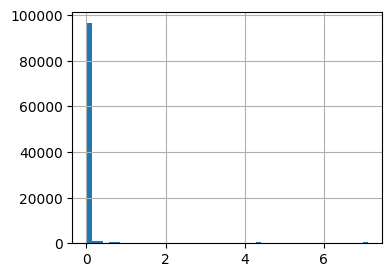

In [16]:
points_gdf_with_stac["cloud_cover"].hist(bins=50, figsize=(4,3))

In [17]:
print("Number of points with no images found:", points_gdf_with_stac["stac_item"].isnull().sum())

Number of points with no images found: 0


### Setup PyTorch data loader

In [18]:
stac_item_list = points_gdf_with_stac.stac_item.tolist()
points_list = points_gdf_with_stac[["Lon", "Lat"]].to_numpy()

In [22]:
points_gdf_with_stac.stac_item

91057    <Item id=S2B_MSIL2A_20220129T053049_R105_T43PD...
91056    <Item id=S2B_MSIL2A_20220129T053049_R105_T43PD...
91062    <Item id=S2B_MSIL2A_20220129T053049_R105_T43PD...
89896    <Item id=S2B_MSIL2A_20220129T053049_R105_T43PD...
89898    <Item id=S2B_MSIL2A_20220129T053049_R105_T43PD...
                               ...                        
99726    <Item id=S2B_MSIL2A_20220221T035759_R004_T46NE...
99722    <Item id=S2B_MSIL2A_20220221T035759_R004_T46NE...
99720    <Item id=S2B_MSIL2A_20220122T040049_R004_T46NE...
99719    <Item id=S2B_MSIL2A_20220122T040049_R004_T46NE...
99718    <Item id=S2B_MSIL2A_20220122T040049_R004_T46NE...
Name: stac_item, Length: 99897, dtype: object

In [26]:
stac_item_list[0]

ID: S2B_MSIL2A_20220129T053049_R105_T43PDR_20220213T192200
Datetime: 2022-01-29 05:30:49.024000+00:00
datetime: 2022-01-29T05:30:49.024000Z
platform: Sentinel-2B
proj:epsg: 32643
instruments: ['msi']
s2:mgrs_tile: 43PDR
constellation: Sentinel 2
s2:granule_id: S2B_OPER_MSI_L2A_TL_ESRI_20220213T192202_A025585_T43PDR_N04.00
eo:cloud_cover: 0.001353
s2:datatake_id: GS2B_20220129T053049_025585_N04.00


In [ ]:
BUFFER_DISTANCE

In [19]:
dataset = CustomDataset(
    points_list,
    stac_item_list, 
    buffer=BUFFER_DISTANCE,
    bands=bands,
    resolution=resolution
)

batch_size = 1 # increase this?
num_workers = os.cpu_count() # AWS can handle *2 since 32GB ram
dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=lambda x: x,
    pin_memory=False,
)

### NOTE: The following clashes with Dask workers! ###
# num_workers=num_workers,
# persistent_workers=True,

tensor([[[0.1112, 0.1125, 0.1088,  ..., 0.0673, 0.0659, 0.0612],
         [0.1099, 0.1059, 0.1052,  ..., 0.0699, 0.0692, 0.0684],
         [0.1074, 0.1048, 0.1052,  ..., 0.0708, 0.0735, 0.0657],
         ...,
         [0.1045, 0.1048, 0.1037,  ..., 0.0885, 0.0845, 0.0735],
         [0.1041, 0.1019, 0.1025,  ..., 0.0661, 0.0652, 0.0517],
         [0.1070, 0.1025, 0.1019,  ..., 0.0353, 0.0324, 0.0342]],

        [[0.1311, 0.1285, 0.1232,  ..., 0.1230, 0.1167, 0.1159],
         [0.1311, 0.1261, 0.1220,  ..., 0.1283, 0.1201, 0.1236],
         [0.1285, 0.1289, 0.1243,  ..., 0.1365, 0.1274, 0.1281],
         ...,
         [0.1190, 0.1172, 0.1125,  ..., 0.1249, 0.1281, 0.1238],
         [0.1161, 0.1169, 0.1136,  ..., 0.1052, 0.0936, 0.0790],
         [0.1169, 0.1134, 0.1150,  ..., 0.0550, 0.0537, 0.0546]],

        [[0.0775, 0.0741, 0.0730,  ..., 0.1139, 0.1181, 0.1161],
         [0.0754, 0.0710, 0.0712,  ..., 0.1147, 0.1169, 0.1190],
         [0.0750, 0.0726, 0.0701,  ..., 0.1187, 0.1169, 0.

### Clear memory

In [17]:
# del client
# del points_gdf
# del points_dgdf
# del points_gdf_with_stac
# del stac_item_list
# # del points_list
# gc.collect()

### Check images

In [18]:
 # for images in dataloader:
 #    for image in images:
 #        array = np.array(image[:3])
 #        array = np.flip(array)
 #        reshaped_array = np.swapaxes(array, 0, 2)
 #        plt.imshow(reshaped_array)
 #        plt.show()

## Define featurization model and apply to images

In [19]:
DEVICE = torch.device("cuda") # change to "cuda" when using GPU
MODEL = RCF(NUM_FEATURES, num_input_channels=NUM_INPUT_CHANNELS).eval().to(DEVICE)

### Apply featurization to images

Full image should be 100x100 pixels (3km^2 at 30m/px), but we can receive smaller images if an input point happens to be at the edge of a scene. To deal with these we crudely drop all images where the spatial dimensions aren't both greater than `min_image_edge` pixels.

In [ ]:
NUM_POINTS = len(points_list)
X_all = np.full([NUM_POINTS, NUM_FEATURES], np.nan, dtype=float)

i = 0
end_index = 0
for images in tqdm(dataloader):
    for image in images:
        if image is not None:
            if image.shape[1] >= min_image_edge and image.shape[2] >= min_image_edge:
                mosaiks_features = featurize(image, MODEL, DEVICE)
                X_all[i] = mosaiks_features
            else:
                # if image size is too small
                pass
        else:
            # if we do have not found an image for some point
            pass
        
        # save to file every 10k points
        if (i!=0 and i%10000==0) or i==NUM_POINTS:
            start_index = end_index
            end_index = i
            X_chunk = X_all[start_index:end_index]

            print(f"Saving {start_index} to {end_index-1}...")
            
            save_features_to_parquet(
                array=X_chunk, 
                points_list=points_list, 
                start_index=start_index, 
                end_index=end_index, 
                output_folder_path=DATA_ROOT/"01_preprocessed/mosaiks_features/", 
                filename_prefix=data_label,
            )
            
            del X_chunk
            gc.collect()

        i += 1

  0%|          | 0/99897 [00:00<?, ?it/s]

0 Error: 


### Save to file (gzipped parquet)

In [ ]:
save_features_to_parquet(
    array=X_all, 
    points_list=points_list,
    output_folder_path=DATA_ROOT/"01_preprocessed/mosaiks_features/", 
    filename_prefix=data_label,
)